In [1]:
%pip install scikit-learn
%pip install pandas
%pip install numpy
%pip install matplotlib



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

url = (
    "https://erddap.aoml.noaa.gov/gdp/erddap/tabledap/drifter_6hour_qc.csv?"
    "ID,time,latitude,lon360,ve,vn&"
    "time%3E%3D2024-01-01T00%3A00%3A00Z&time%3C%3D2024-12-31T23%3A59%3A59Z&"
    "latitude%3E%3D14&latitude%3C%3D32&lon360%3E%3D255&lon360%3C%3D300"
)
df_raw = pd.read_csv(url)
df = df_raw[pd.to_numeric(df_raw['latitude'], errors='coerce').notnull()].copy()
features = ['latitude', 'lon360', 've', 'vn']
scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[features] = scaler.fit_transform(df[features])
print("Data shape:", df_scaled.shape)
print("Unique drifters:", df_scaled['ID'].nunique())
print(df_scaled.head())
print(df_scaled[features].describe())


Data shape: (46018, 6)
Unique drifters: 136
             ID                  time  latitude    lon360        ve        vn
1  3.002341e+14  2024-01-08T00:00:00Z -2.746418 -1.168053  0.053021  0.053022
2  3.002341e+14  2024-01-08T06:00:00Z -2.743061 -1.168053  0.053020  0.053021
3  3.002341e+14  2024-01-08T12:00:00Z -2.739463 -1.169776  0.053020  0.053022
4  3.002341e+14  2024-01-08T18:00:00Z -2.732987 -1.170530  0.053020  0.053022
5  3.002341e+14  2024-01-09T00:00:00Z -2.727231 -1.171391  0.053020  0.053022
           latitude        lon360            ve            vn
count  4.601800e+04  4.601800e+04  4.601800e+04  4.601800e+04
mean  -1.581111e-16  4.743334e-16  1.544054e-18 -1.111719e-17
std    1.000011e+00  1.000011e+00  1.000011e+00  1.000011e+00
min   -2.750496e+00 -2.814816e+00 -1.886077e+01 -1.886077e+01
25%   -5.044267e-01 -5.905547e-01  5.301724e-02  5.301751e-02
50%    1.468494e-01  2.201179e-01  5.301994e-02  5.301990e-02
75%    7.803775e-01  8.546979e-01  5.302255e-02  5.302

In [4]:
num_drifters = df_scaled['ID'].nunique()
print(f"There are {num_drifters} unique drifters in the dataset.")


There are 136 unique drifters in the dataset.


In [11]:
%pip install kneed


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator
import numpy as np
import pandas as pd

features = ['latitude', 'lon360', 've', 'vn']
all_results = []
for drifter_id in df_scaled['ID'].unique():
    df_d = df_scaled[df_scaled['ID'] == drifter_id].copy()
    df_d = df_d.dropna(subset=features)

    if len(df_d) < 10:
        continue

    X = df_d[features].values
    X_scaled = StandardScaler().fit_transform(X)
    min_samples = 3
    k = min_samples - 1
    neighbors = NearestNeighbors(n_neighbors=k + 1)
    neighbors_fit = neighbors.fit(X_scaled)
    distances, indices = neighbors_fit.kneighbors(X_scaled)
    k_distances = np.sort(distances[:, k])

    try:
        kneedle = KneeLocator(range(len(k_distances)), k_distances, curve='convex', direction='increasing')
        eps_optimal = k_distances[kneedle.knee] if kneedle.knee is not None else 0.5
    except:
        eps_optimal = 0.5
    dbscan = DBSCAN(eps=eps_optimal, min_samples=min_samples)
    labels = dbscan.fit_predict(X_scaled)
    df_d['cluster'] = labels
    df_d['is_anomaly'] = labels == -1
    df_d['eps_used'] = eps_optimal
    all_results.append(df_d)

df_all_drifters_labeled = pd.concat(all_results, ignore_index=True)


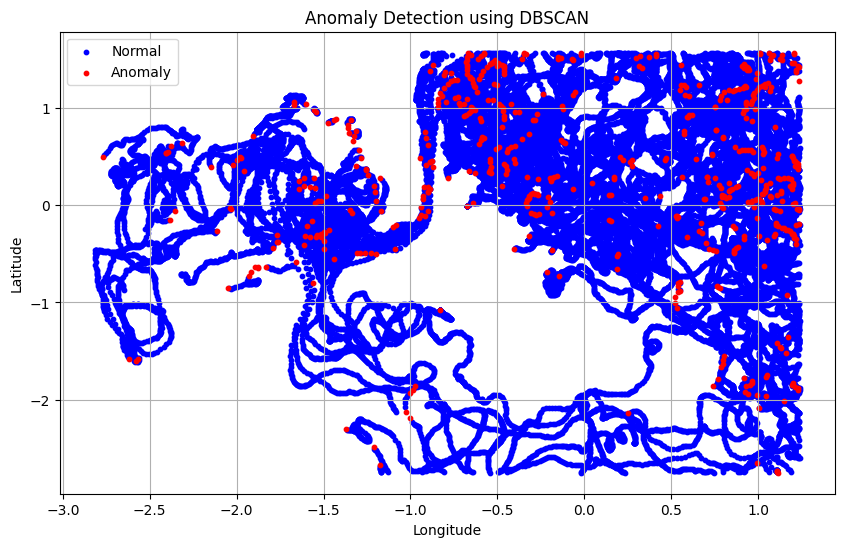

In [ ]:
plt.figure(figsize=(10, 6))
normal = df_all_drifters_labeled[df_all_drifters_labeled['is_anomaly'] == False]
anomaly = df_all_drifters_labeled[df_all_drifters_labeled['is_anomaly'] == True]
plt.scatter(normal['lon360'], normal['latitude'], c='blue', s=10, label='Normal')
plt.scatter(anomaly['lon360'], anomaly['latitude'], c='red', s=10, label='Anomaly')
plt.title('Anomaly Detection using DBSCAN')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
num_anomalies = df_all_drifters_labeled['is_anomaly'].sum()
print(f"Number of DBSCAN anomalies detected: {num_anomalies}")


Number of DBSCAN anomalies detected: 595


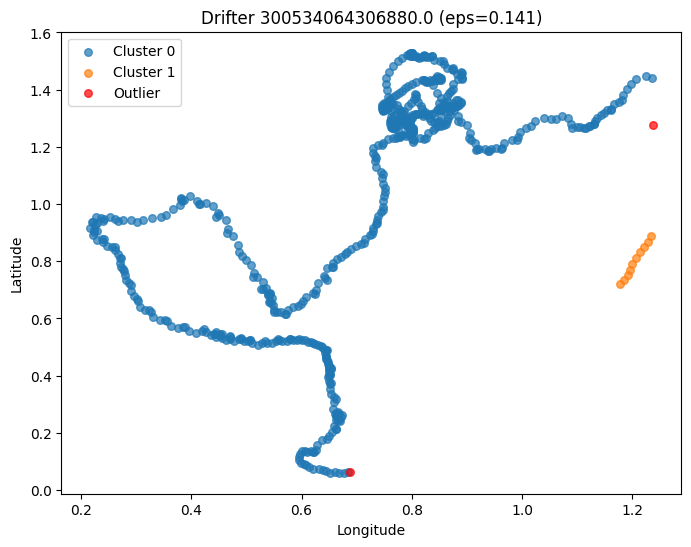

In [ ]:
example_id = df_all_drifters_labeled['ID'].sample(1).values[0]
df_example = df_all_drifters_labeled[df_all_drifters_labeled['ID'] == example_id]
plt.figure(figsize=(8, 6))
for label in set(df_example['cluster']):
    mask = df_example['cluster'] == label
    color = 'red' if label == -1 else None
    plt.scatter(df_example[mask]['lon360'], df_example[mask]['latitude'],
                label='Outlier' if label == -1 else f'Cluster {label}', s=30, alpha=0.7, c=color)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f"Drifter {example_id} (eps={df_example['eps_used'].iloc[0]:.3f})")
plt.legend()
plt.show()


LOOK HERE

In [ ]:
import os
import random
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, precision_recall_curve, auc
from tensorflow.keras import layers, models, callbacks, backend as K
import matplotlib.pyplot as plt
import pandas as pd

def set_seed(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

features = ['latitude', 'lon360', 've', 'vn']
window_size = 10
stride = 1

X_seq, y_seq = [], []
for drifter_id in df_all_drifters_labeled['ID'].unique():
    df_drifter = df_all_drifters_labeled[df_all_drifters_labeled['ID'] == drifter_id]
    df_drifter = df_drifter.dropna(subset=features + ['is_anomaly'])
    if len(df_drifter) < window_size:
        continue
    values = df_drifter[features].values
    labels = df_drifter['is_anomaly'].values
    for i in range(0, len(values) - window_size + 1, stride):
        X_seq.append(values[i:i + window_size])
        y_seq.append(int(np.max(labels[i:i + window_size])))

X_seq = np.array(X_seq)
y_seq = np.array(y_seq)
print(f"X_seq shape: {X_seq.shape}, y_seq shape: {y_seq.shape}, Total anomalies: {np.sum(y_seq)}")
def focal_loss(alpha=0.25, gamma=2.0):
    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        bce = K.binary_crossentropy(y_true, y_pred)
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        return alpha * K.pow(1 - p_t, gamma) * bce
    return loss
def build_cnn(input_shape):
    model = models.Sequential([
        layers.Conv1D(64, 3, activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling1D(),
        layers.Conv1D(128, 3, activation='relu', padding='same'),
        layers.GlobalMaxPooling1D(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    return model
def evaluate_metrics(y_true, y_pred_probs):
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_pred_probs)
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)
    best_idx = np.argmax(f1_scores)
    best_thresh = thresholds[best_idx]
    y_pred = (y_pred_probs >= best_thresh).astype(int)
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0),
        'f1': f1_score(y_true, y_pred, zero_division=0),
        'roc_auc': roc_auc_score(y_true, y_pred_probs),
        'pr_auc': auc(recalls, precisions),
        'best_thresh': best_thresh
    }
    cm = confusion_matrix(y_true, y_pred)
    return metrics, cm
def run_experiment(X_seq, y_seq, test_size=0.2, n_runs=10, epochs=20, batch_size=64):
    all_metrics = []
    all_cms = []
    for run_idx in range(n_runs):
        seed = 1000 + run_idx
        set_seed(seed)
        X_train_seq, X_val_seq, y_train_seq, y_val_seq = train_test_split(
            X_seq, y_seq, test_size=test_size, random_state=seed, stratify=y_seq
        )
        X_pos = X_train_seq[y_train_seq == 1]
        y_pos = y_train_seq[y_train_seq == 1]
        X_neg = X_train_seq[y_train_seq == 0]
        y_neg = y_train_seq[y_train_seq == 0]
        X_pos_upsampled, y_pos_upsampled = resample(
            X_pos, y_pos, replace=True, n_samples=len(y_neg), random_state=seed
        )
        X_train_bal = np.concatenate([X_neg, X_pos_upsampled])
        y_train_bal = np.concatenate([y_neg, y_pos_upsampled])
        shuffle_idx = np.random.permutation(len(X_train_bal))
        X_train_bal, y_train_bal = X_train_bal[shuffle_idx], y_train_bal[shuffle_idx]

        alpha = 1 - np.mean(y_train_bal)
        model = build_cnn((X_train_bal.shape[1], X_train_bal.shape[2]))
        model.compile(
            optimizer='adam',
            loss=focal_loss(alpha=alpha, gamma=1.0),
            metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()]
        )
        early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
        model.fit(
            X_train_bal, y_train_bal,
            validation_data=(X_val_seq, y_val_seq),
            epochs=epochs, batch_size=batch_size,
            callbacks=[early_stop],
            verbose=0
        )
        y_val_probs = model.predict(X_val_seq, verbose=0).ravel()
        metrics, cm = evaluate_metrics(y_val_seq, y_val_probs)
        metrics['seed'] = seed
        all_metrics.append(metrics)
        all_cms.append(cm)
        print(f"Run {run_idx+1}/{n_runs}, Seed {seed}, Acc={metrics['accuracy']:.3f}, F1={metrics['f1']:.3f}")
    return all_metrics, all_cms

def average_confusion_matrices(cms):
    sum_cm = np.zeros_like(cms[0], dtype=float)
    for cm in cms:
        sum_cm += cm
    return sum_cm / len(cms)
n_runs = 10
metrics_cnn, cms_cnn = run_experiment(X_seq, y_seq, test_size=0.2, n_runs=n_runs)
avg_cm_cnn = average_confusion_matrices(cms_cnn)
df_metrics_cnn = pd.DataFrame(metrics_cnn)
print("Average Confusion Matrix (80/20 CNN):\n", avg_cm_cnn)
print("\nPer-run metrics:\n", df_metrics_cnn)


X_seq shape: (44807, 10, 4), y_seq shape: (44807,), Total anomalies: 2247


/Users/candy/finalproject/tf-env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-10-18 01:12:10.191487: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2025-10-18 01:12:10.191524: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-10-18 01:12:10.191534: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-10-18 01:12:10.191555: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-10-18 01:12:10.191576: I tensorflow/core/common_runtime/pluggable_device/pluggable_device

Run 1/10, Seed 1000, Acc=0.876, F1=0.278


/Users/candy/finalproject/tf-env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Run 2/10, Seed 1001, Acc=0.942, F1=0.261


/Users/candy/finalproject/tf-env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Run 3/10, Seed 1002, Acc=0.939, F1=0.369


/Users/candy/finalproject/tf-env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Run 4/10, Seed 1003, Acc=0.937, F1=0.339


/Users/candy/finalproject/tf-env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Run 5/10, Seed 1004, Acc=0.914, F1=0.303


/Users/candy/finalproject/tf-env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Run 6/10, Seed 1005, Acc=0.929, F1=0.277


/Users/candy/finalproject/tf-env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Run 7/10, Seed 1006, Acc=0.939, F1=0.261


/Users/candy/finalproject/tf-env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Run 8/10, Seed 1007, Acc=0.940, F1=0.352


/Users/candy/finalproject/tf-env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Run 9/10, Seed 1008, Acc=0.946, F1=0.235


/Users/candy/finalproject/tf-env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Run 10/10, Seed 1009, Acc=0.939, F1=0.319
Average Confusion Matrix (80/20 CNN):
 [[8200.3  312.7]
 [ 314.3  134.7]]

Per-run metrics:
    accuracy  precision    recall        f1   roc_auc    pr_auc  best_thresh  \
0  0.875586   0.196168  0.478842  0.278317  0.815692  0.259474     0.613373   
1  0.941977   0.360784  0.204900  0.261364  0.787349  0.257739     0.652592   
2  0.938630   0.380615  0.358575  0.369266  0.803775  0.325245     0.626919   
3  0.936956   0.357143  0.322940  0.339181  0.794571  0.314359     0.548136   
4  0.914305   0.255743  0.371938  0.303085  0.802806  0.264007     0.559985   
5  0.929480   0.284706  0.269488  0.276888  0.788495  0.249728     0.618137   
6  0.938741   0.329932  0.216036  0.261104  0.759621  0.239226     0.638301   
7  0.939969   0.383202  0.325167  0.351807  0.810328  0.317634     0.607886   
8  0.945659   0.398936  0.167038  0.235479  0.743076  0.225104     0.668360   
9  0.939076   0.362606  0.285078  0.319202  0.824694  0.292674     0.622893

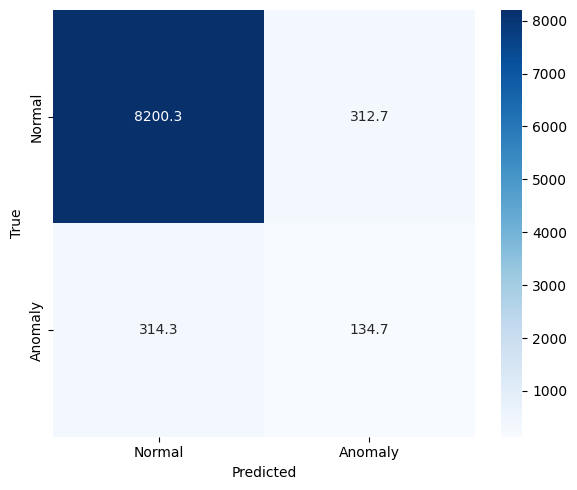

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
conf_matrix = np.array([[8200.3, 312.7],
                        [314.3, 134.7]])

labels = ['Normal', 'Anomaly']
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt=".1f", cmap="Blues", xticklabels=labels, yticklabels=labels, cbar=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()


In [ ]:
def build_lstm(input_shape):
    inputs = layers.Input(shape=input_shape)
    x = layers.LSTM(64, return_sequences=True)(inputs)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    return models.Model(inputs, outputs)

def run_experiment_lstm(X_seq, y_seq, test_size=0.2, n_runs=10, epochs=20, batch_size=64):
    all_metrics = []
    all_cms = []
    for run_idx in range(n_runs):
        seed = 2000 + run_idx  
        set_seed(seed)
        X_train_seq, X_val_seq, y_train_seq, y_val_seq = train_test_split(
            X_seq, y_seq, test_size=test_size, random_state=seed, stratify=y_seq
        )
        X_pos = X_train_seq[y_train_seq == 1]
        y_pos = y_train_seq[y_train_seq == 1]
        X_neg = X_train_seq[y_train_seq == 0]
        y_neg = y_train_seq[y_train_seq == 0]
        X_pos_upsampled, y_pos_upsampled = resample(
            X_pos, y_pos, replace=True, n_samples=len(y_neg), random_state=seed
        )
        X_train_bal = np.concatenate([X_neg, X_pos_upsampled])
        y_train_bal = np.concatenate([y_neg, y_pos_upsampled])
        shuffle_idx = np.random.permutation(len(X_train_bal))
        X_train_bal, y_train_bal = X_train_bal[shuffle_idx], y_train_bal[shuffle_idx]

        alpha = 1 - np.mean(y_train_bal)
        input_shape = (X_train_bal.shape[1], X_train_bal.shape[2])
        model = build_lstm(input_shape)
        model.compile(
            optimizer='adam',
            loss=focal_loss(alpha=alpha, gamma=1.0),
            metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()]
        )
        early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
        model.fit(
            X_train_bal, y_train_bal,
            validation_data=(X_val_seq, y_val_seq),
            epochs=epochs, batch_size=batch_size,
            callbacks=[early_stop],
            verbose=0
        )
        y_val_probs = model.predict(X_val_seq, verbose=0).ravel()
        metrics, cm = evaluate_metrics(y_val_seq, y_val_probs)
        metrics['seed'] = seed
        all_metrics.append(metrics)
        all_cms.append(cm)
        print(f"LSTM Run {run_idx+1}/{n_runs}, Seed {seed}, Acc={metrics['accuracy']:.3f}, F1={metrics['f1']:.3f}")
    return all_metrics, all_cms

metrics_lstm, cms_lstm = run_experiment_lstm(X_seq, y_seq, test_size=0.2, n_runs=n_runs)
avg_cm_lstm = average_confusion_matrices(cms_lstm)
df_metrics_lstm = pd.DataFrame(metrics_lstm)
print("Average Confusion Matrix (80/20 LSTM):\n", avg_cm_lstm)
print("\nPer-run metrics (LSTM):\n", df_metrics_lstm)


LSTM Run 1/10, Seed 2000, Acc=0.933, F1=0.257
LSTM Run 2/10, Seed 2001, Acc=0.900, F1=0.291
LSTM Run 3/10, Seed 2002, Acc=0.886, F1=0.239
LSTM Run 4/10, Seed 2003, Acc=0.893, F1=0.261
LSTM Run 5/10, Seed 2004, Acc=0.872, F1=0.286
LSTM Run 6/10, Seed 2005, Acc=0.920, F1=0.266
LSTM Run 7/10, Seed 2006, Acc=0.898, F1=0.272
LSTM Run 8/10, Seed 2007, Acc=0.857, F1=0.257
LSTM Run 9/10, Seed 2008, Acc=0.908, F1=0.270
LSTM Run 10/10, Seed 2009, Acc=0.909, F1=0.261
Average Confusion Matrix (80/20 LSTM):
 [[7879.1  633.9]
 [ 282.6  166.4]]

Per-run metrics (LSTM):
    accuracy  precision    recall        f1   roc_auc    pr_auc  best_thresh  \
0  0.932939   0.288889  0.231626  0.257108  0.809199  0.230982     0.707390   
1  0.900469   0.226205  0.407572  0.290938  0.825465  0.250766     0.639186   
2  0.886409   0.179978  0.356347  0.239163  0.752244  0.203413     0.587295   
3  0.893216   0.199764  0.376392  0.261004  0.789055  0.217356     0.617420   
4  0.872238   0.198440  0.510022  0.285714 

In [ ]:
import os
import random
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, precision_recall_curve, auc
)
def set_seed(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
features = ['latitude', 'lon360', 've', 'vn']
window_size = 10
stride = 1
X_seq, y_seq = [], []
for drifter_id in df_all_drifters_labeled['ID'].unique():
    df_drifter = df_all_drifters_labeled[df_all_drifters_labeled['ID'] == drifter_id]
    df_drifter = df_drifter.dropna(subset=features + ['is_anomaly'])
    if len(df_drifter) < window_size:
        continue
    values = df_drifter[features].values
    labels = df_drifter['is_anomaly'].values
    for i in range(0, len(values) - window_size + 1, stride):
        X_seq.append(values[i:i + window_size])
        y_seq.append(int(np.max(labels[i:i + window_size])))
X_seq = np.array(X_seq)
y_seq = np.array(y_seq)
print(f"Sliding windows: {X_seq.shape}, labels: {y_seq.shape}, Total anomalies: {np.sum(y_seq)}")

X_mean = np.mean(X_seq, axis=1)
X_std = np.std(X_seq, axis=1)
X_max = np.max(X_seq, axis=1)
X_min = np.min(X_seq, axis=1)
X_agg = np.concatenate([X_mean, X_std, X_max, X_min], axis=1)

seeds = list(range(10))
all_metrics_lr = []
for seed in seeds:
    set_seed(seed)
    X_train, X_val, y_train, y_val = train_test_split(
        X_agg, y_seq, test_size=0.2, stratify=y_seq, random_state=seed
    )

    X_pos = X_train[y_train==1]
    y_pos = y_train[y_train==1]
    X_neg = X_train[y_train==0]
    y_neg = y_train[y_train==0]
    if len(X_pos) > 0:
        X_pos_upsampled, y_pos_upsampled = resample(
            X_pos, y_pos, replace=True, n_samples=len(y_neg), random_state=seed
        )
        X_train_bal = np.concatenate([X_neg, X_pos_upsampled])
        y_train_bal = np.concatenate([y_neg, y_pos_upsampled])
    else:
        X_train_bal, y_train_bal = X_train, y_train  
    shuffle_idx = np.random.permutation(len(X_train_bal))
    X_train_bal, y_train_bal = X_train_bal[shuffle_idx], y_train_bal[shuffle_idx]
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_bal)
    X_val_scaled = scaler.transform(X_val)

    model_lr = LogisticRegression(class_weight='balanced', solver='liblinear', max_iter=1000, random_state=seed)
    model_lr.fit(X_train_scaled, y_train_bal)
    y_val_probs = model_lr.predict_proba(X_val_scaled)[:, 1]

    precisions, recalls, thresholds = precision_recall_curve(y_val, y_val_probs)
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)
    best_idx = np.argmax(f1_scores)
    best_thresh = thresholds[best_idx] if len(thresholds) > 0 else 0.5
    y_val_pred = (y_val_probs >= best_thresh).astype(int)
    metrics = {
        'seed': seed,
        'accuracy': accuracy_score(y_val, y_val_pred),
        'precision': precision_score(y_val, y_val_pred, zero_division=0),
        'recall': recall_score(y_val, y_val_pred, zero_division=0),
        'f1': f1_score(y_val, y_val_pred, zero_division=0),
        'roc_auc': roc_auc_score(y_val, y_val_probs),
        'pr_auc': auc(recalls, precisions),
        'best_thresh': best_thresh
    }
    all_metrics_lr.append(metrics)
    print(f"Seed {seed} done: Acc={metrics['accuracy']:.3f}, F1={metrics['f1']:.3f}")

df_metrics_lr = pd.DataFrame(all_metrics_lr)
print(df_metrics_lr.describe())


Sliding windows: (44807, 10, 4), labels: (44807,), Total anomalies: 2247
Seed 0 done: Acc=0.933, F1=0.362
Seed 1 done: Acc=0.935, F1=0.304
Seed 2 done: Acc=0.939, F1=0.336
Seed 3 done: Acc=0.903, F1=0.313
Seed 4 done: Acc=0.936, F1=0.334
Seed 5 done: Acc=0.930, F1=0.345
Seed 6 done: Acc=0.926, F1=0.329
Seed 7 done: Acc=0.927, F1=0.324
Seed 8 done: Acc=0.909, F1=0.293
Seed 9 done: Acc=0.930, F1=0.339
           seed   accuracy  precision     recall         f1    roc_auc  \
count  10.00000  10.000000  10.000000  10.000000  10.000000  10.000000   
mean    4.50000   0.926824   0.312556   0.354343   0.327840   0.822722   
std     3.02765   0.011807   0.042764   0.043548   0.020223   0.009313   
min     0.00000   0.903035   0.239437   0.282851   0.293356   0.808618   
25%     2.25000   0.926328   0.301738   0.327951   0.315794   0.815589   
50%     4.50000   0.930261   0.324338   0.358575   0.331160   0.822673   
75%     6.75000   0.934669   0.342911   0.374165   0.338174   0.830042   
max  

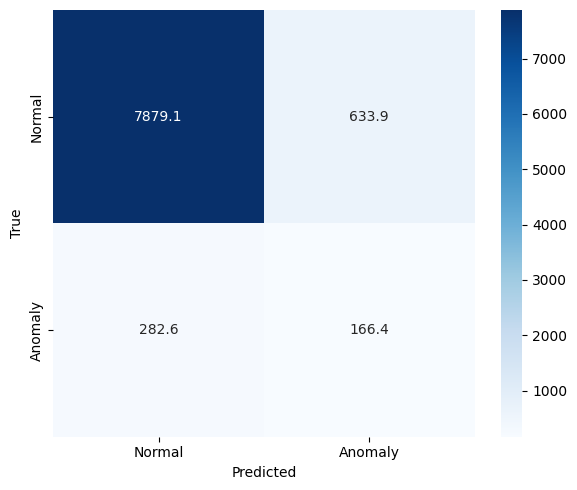

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
conf_matrix = np.array([[7879.1, 633.9],
                        [282.6, 166.4]])
labels = ['Normal', 'Anomaly']
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt=".1f", cmap="Blues", xticklabels=labels, yticklabels=labels, cbar=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()


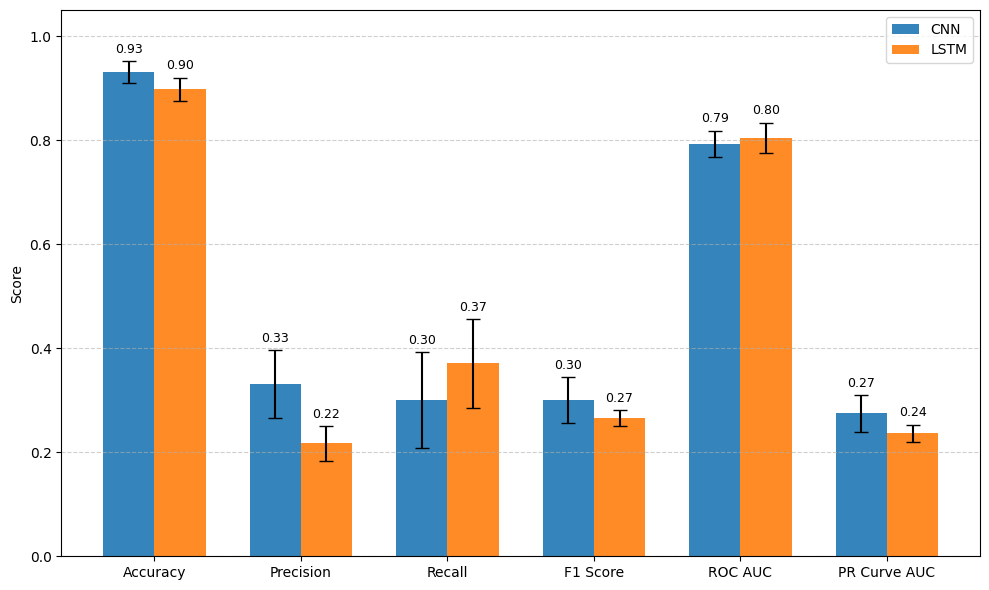

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'pr_auc']
labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC', 'PR Curve AUC']
cnn_means = [df_metrics_cnn[m].mean() for m in metrics_to_plot]
cnn_stds = [df_metrics_cnn[m].std() for m in metrics_to_plot]
lstm_means = [df_metrics_lstm[m].mean() for m in metrics_to_plot]
lstm_stds = [df_metrics_lstm[m].std() for m in metrics_to_plot]

x = np.arange(len(labels))
width = 0.35
plt.figure(figsize=(10, 6))
bars1 = plt.bar(x - width/2, cnn_means, width, yerr=cnn_stds, capsize=5, label='CNN', color='#1f77b4', alpha=0.9)
bars2 = plt.bar(x + width/2, lstm_means, width, yerr=lstm_stds, capsize=5, label='LSTM', color='#ff7f0e', alpha=0.9)
plt.ylabel('Score')
plt.ylim(0, 1.05)
plt.xticks(x, labels)
plt.legend()
for bars, means, stds in zip([bars1, bars2], [cnn_means, lstm_means], [cnn_stds, lstm_stds]):
    for bar, mean, std in zip(bars, means, stds):
        offset = std + 0.01
        plt.annotate(f'{mean:.2f}',
                     xy=(bar.get_x() + bar.get_width() / 2, mean + offset),
                     xytext=(0, 0),
                     textcoords="offset points",
                     ha='center', va='bottom',
                     fontsize=9)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


95% CI for mean difference (CNN - LSTM): [0.0026, 0.0663]
Observed mean difference         : 0.0335


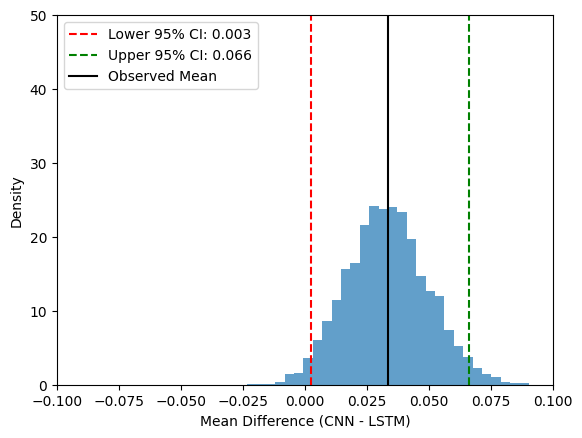

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

f1_cnn = df_metrics_cnn['f1'].values
f1_lstm = df_metrics_lstm['f1'].values
assert f1_cnn.shape == f1_lstm.shape, "CNN and LSTM arrays must be same length"
N = len(f1_cnn)

def shuffle_in_blocks(arr1, arr2, block_size):
    n = len(arr1)
    n_blocks = n // block_size
    leftover = n % block_size
    b1 = arr1[:n_blocks*block_size].reshape(n_blocks, block_size)
    b2 = arr2[:n_blocks*block_size].reshape(n_blocks, block_size)
    perm = np.random.permutation(n_blocks)
    s1 = b1[perm].reshape(-1)
    s2 = b2[perm].reshape(-1)
    if leftover:
        s1 = np.concatenate([s1, arr1[-leftover:]])
        s2 = np.concatenate([s2, arr2[-leftover:]])
    return s1, s2

def bootstrap_mean_diff(arr1, arr2, block_size=2, n_boot=5000, ci=95):
    diffs = np.empty(n_boot)
    n = len(arr1)
    for i in range(n_boot):
        s1, s2 = shuffle_in_blocks(arr1, arr2, block_size)
        idx = np.random.choice(n, n, replace=True)
        diffs[i] = np.mean(s1[idx] - s2[idx])
    lower = np.percentile(diffs, (100 - ci) / 2)
    upper = np.percentile(diffs, 100 - (100 - ci) / 2)
    obs_diff = np.mean(arr1 - arr2)
    print(f"{ci}% CI for mean difference (CNN - LSTM): [{lower:.4f}, {upper:.4f}]")
    print(f"Observed mean difference         : {obs_diff:.4f}")
    return diffs, lower, upper

boot_diffs, ci_lo, ci_hi = bootstrap_mean_diff(f1_cnn, f1_lstm, block_size=2, n_boot=5000)
plt.hist(boot_diffs, bins=30, density=True, alpha=0.7)
plt.axvline(ci_lo, color='red', linestyle='--', label=f"Lower 95% CI: {ci_lo:.3f}")
plt.axvline(ci_hi, color='green', linestyle='--', label=f"Upper 95% CI: {ci_hi:.3f}")
plt.axvline(np.mean(f1_cnn - f1_lstm), color='black', linestyle='-', label="Observed Mean")
plt.xlim(-0.1, 0.1)
plt.ylim(0,50)
plt.xlabel("Mean Difference (CNN - LSTM)")
plt.ylabel("Density")
plt.legend()
plt.show()
